# Import all used packages

In [1]:
import pandas as pd
import numpy as np
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow .keras.optimizers import Adam
import keras
from sklearn.metrics import accuracy_score
from keras import optimizers
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import pickle
import datetime

import warnings
#from pandas.tseries.offsets import DateOffset
warnings.filterwarnings('ignore')

# Load in data in respective periods
This is done to alleviate the issue of our machines running out of memory when running code, thus only load in data that is needed for respective period.

### 2005-2011

In [2]:
optimal_df = pickle.load( open( "optimal_df_05-11.p", "rb" ) )
X_test = pickle.load( open( "save_X_test_05_11.p", "rb" ) )
y_test = pickle.load( open( "save_y_test_05_11.p", "rb" ) )
dates_df_test_pf = pickle.load( open( "dates_df_test_pf.p", "rb" ) )
pred_period = 0

### 2012-2018

In [3]:
optimal_df = pickle.load( open( "optimal_df_12-18.p", "rb" ) )
X_test = pickle.load( open( "save_X_test_12_18.p", "rb" ) )
y_test = pickle.load( open( "save_y_test_12_18.p", "rb" ) )
dates_df_test_pf = pickle.load( open( "dates_df_test_pf_12_18.p", "rb" ) )
pred_period = 1

### 2019-2022

In [4]:
optimal_df = pickle.load( open( "optimal_df_19-22.p", "rb" ) )
X_test = pickle.load( open( "save_X_test_19_22.p", "rb" ) )
y_test = pickle.load( open( "save_y_test_19_22.p", "rb" ) )
dates_df_test_pf = pickle.load( open( "dates_df_test_pf_19_22.p", "rb" ) )
pred_period = 2

# Load in NASDAQ 100 data
Load in Nasdaq 100 data that is used in the portfolio section

In [5]:
# Here we calculate the average monthly return for each period we are considering. This is used for the rebalancing threshold.
Nasdaq100_index = pd.read_csv("NASDAQ100_index.csv")
Nasdaq_avg_ret = []
for i in range(3):
    if i == 0:       
        plot_nas = Nasdaq100_index[(Nasdaq100_index["DATE"]>="2005-01-31") & (Nasdaq100_index["DATE"]<"2012-02-01")]["NASDAQ100"].tolist()
    elif i == 1:     
        plot_nas = Nasdaq100_index[(Nasdaq100_index["DATE"]>="2012-01-31") & (Nasdaq100_index["DATE"]<"2019-02-01")]["NASDAQ100"].tolist()
    elif i == 2:
        plot_nas = Nasdaq100_index[(Nasdaq100_index["DATE"]>="2019-01-31") & (Nasdaq100_index["DATE"]<"2023-02-01")]["NASDAQ100"].tolist()
    # The data has "." in a lot of places, that we remove
    for x in plot_nas[:]:
        if x == '.':
            plot_nas.remove(x) 
    # The dataformat is also strings, so we convert to float
    plot_nas = [float(x) for x in plot_nas]
    # Calculate returns
    ret_nas = []
    for i in range(1,len(plot_nas)):
        ret_nas.append(plot_nas[i]/plot_nas[i-1]-1)
    Nasdaq_avg_ret.append(sum(ret_nas)/np.ceil(len(ret_nas)/21)) # Calculate average return in period


Nasdaq_avg_ret

[0.008280178107935323, 0.013346305965169048, 0.014801658109719847]

# Portfolio stuff

In [6]:
# If model is not run from beginning, but pickled data is loaded in, run this to assign variables
input_size = 12

We are now ready for the portfolio stuff. 

First function is what goes through every month and manages portfolios.

In [7]:
def optimal_hyper(optimal_df,X_test,y_test,dates_df_test_pf, frequency,pred_period):
    df = pd.DataFrame(columns = ("ls_ret_eq","ls_ret_mc","bh_ret_eq","bh_ret_mc")) # Create df that will save returns from all portfolios each month
    # We need to keep track of the current year and month that we are running through. Start is year 0 month 0.
    year = -1 # make sure modulus starts at right point, year will be increasesed to 0. This is done beacuse when i=0 we will go into year increase
    month = 0
    
    rebal = 1 # Initialize paramater that keeps track of when we are in a month where we can rebalance
    
    bh_ret_eq,bh_ret_mc = 0,0 # we have no return from buy/hold in first period
    bh_value_eq,bh_value_mc = 100,100 # Start with $100 (We actually ended up not using the value)
    bh_pf_eq,bh_pf_mc = pd.DataFrame(),pd.DataFrame() # we have no portfolios in first period
    portfolio_stocks = {} # Initialize dictionary that will hold all stocks we use for every month
    returns_list = [] # Initialize list that will save returns from every portfolio for every month
    
    save_i = [] # ALlocate storage to save indexes of rebalance points 
    for i in range(len(optimal_df)):
        # First if-statement keeps track of when we can rebalance
        if i %frequency !=0: # If freq is 1 then we rebalance every month. If freq is 3, we can rebalance every third month and so on
            bh_ret_eq = 999 # If we are in a month where we can NOT rebalance, we just set the return to a large value, so we do not enter rebalance in make_pf func
            bh_ret_mc = 999 
            rebal = 0 # Set rebal = 0 when we can not rebalance
        elif i%frequency == 0: # In a month we can rebalance, save the index, so we can plot it
            save_i.append(i)
        
        temp = optimal_df.iloc[i] # Save current month's predictions etc. in temp value
        
        # Update year every 12th index, at the same time set month to 0 for the new year
        if i %12 == 0:
            year = year+1
            month = 0
        
        # Run select_stocks to save tickers, predicitons, true returns, and market cap for each month
        portfolio_stocks[i] = select_stocks(temp["pred"],np.array(y_test[year][month]),dates_df_test_pf,year,month)
        # Run make_pf to create/update/manage portfolios for every month - function returns:
        # Returns from both long/short pf
        # Stocks in both buy/hold pf, returns from both buy/hold, value of both buy/hold
        ls_ret_eq, ls_ret_mc, bh_pf_eq, bh_pf_mc, bh_ret_eq, bh_ret_mc, bh_value_eq, bh_value_mc = make_pf(portfolio_stocks[i],bh_ret_eq,bh_ret_mc,bh_value_eq,bh_value_mc,bh_pf_eq,bh_pf_mc,Nasdaq_avg_ret[pred_period],rebal )

        df.loc[len(df)] = [ls_ret_eq,ls_ret_mc,bh_ret_eq,bh_ret_mc] # Save returns in df
        
        returns_list.append([ls_ret_eq,ls_ret_mc,bh_ret_eq,bh_ret_mc]) # Save returns in list (we ended up not using this)
        
        month = month+1 #increase 1 month
        rebal = 1 # Reset rebal for next month
    df = df.reset_index(drop=True)
    return df, portfolio_stocks, returns_list, save_i

In [8]:
def select_stocks(pred_ret,true_ret,dates_df_test_pf,year,month):
    # Function gathers tickers, predicted returns, true returns, and market cap for all stocks
    tic_cap = pd.DataFrame() 
    for l in range(2,len(dates_df_test_pf[year][month]),input_size): # Get tickers from dates_df_test_pf, but only need 1 instance per firm
        tic_cap = tic_cap.append(dates_df_test_pf[year][month][l:l+1])
    
    df = pd.DataFrame(columns = ("tic","pred","true","market cap"))
    df["tic"] = tic_cap["tic"]
    df["pred"] = np.exp(pred_ret)-1 #Transform log-returns to normal returns
    df["true"] = np.exp(true_ret)-1 #Transform log-returns to normal returns
    df["market cap"] = tic_cap["mkt cap"]
    df = df.sort_values("pred",ascending=False) # Sort everything according to predicted returns - highest to lowest
    return df

In [9]:
def make_pf(df,bh_ret_eq,bh_ret_mc,bh_value_eq,bh_value_mc,bh_pf_eq,bh_pf_mc,Nasdaq_avg_ret,rebal):
    # Function should create 2 portfolios: Long/short & buy/hold
    
    '''_______________ long/short _______________''' 
    # First create long/short portfolios that go long in top 10% performing stocks and short in bottom 10% performing stocks
    
    ls_pf = df.copy().drop(df.index[int(len(df)*0.1):int(len(df)*0.9)]).reset_index(drop=True) # Create df 20% of the length of input stocks

    if len(ls_pf) % 2 != 0: # For zero-net investment, we make sure that we long and short same amount of stocks
        ls_pf = ls_pf.drop(np.floor(len(ls_pf)/2)).reset_index(drop=True) # Thus, if we have odd amount of stocks, remove middle index
    
    # Equal weight
    ls_pf["equal"] = (ls_pf["true"])*1/(len(ls_pf)/2) # Multiply both long and short positions with 1/(length of long/short)
    ls_pf["equal"].iloc[len(ls_pf)//2:] = ls_pf["equal"].iloc[len(ls_pf)//2:]*(-1) # Multiply short positions with minus 1 (get opposite sign returns)
    ls_ret_eq = np.sum(ls_pf["equal"]) # The return of the portfolio will be the sum of the returns
    
    # Market cap weight
    # For the market-cap-weighted do the same as above, but this time multiply by weights: mkt_cap/(total mkt_cap of long/short positions)
    ls_pf["mkt_cap"] = (ls_pf["true"])
    ls_pf["mkt_cap"].iloc[:len(ls_pf)//2] = ls_pf["mkt_cap"].iloc[:len(ls_pf)//2]*1*ls_pf["market cap"].iloc[:len(ls_pf)//2]/sum(ls_pf["market cap"].iloc[:len(ls_pf)//2])
    ls_pf["mkt_cap"].iloc[len(ls_pf)//2:] = ls_pf["mkt_cap"].iloc[len(ls_pf)//2:]*(-1)*ls_pf["market cap"].iloc[len(ls_pf)//2:]/sum(ls_pf["market cap"].iloc[len(ls_pf)//2:])
    ls_ret_mc = np.sum(ls_pf["mkt_cap"]) # The return of the portfolio will be the sum of the returns
    
    
    '''_______________ buy/hold _______________'''
    # Next create buy/hold portfolios that buy stocks with positive predictions and holds, and goes cash when market goes down
    
    # Equal weight
    # Check if we should rebalance or not depending on the return from previous period
    if bh_ret_eq >= Nasdaq_avg_ret:
        if bh_pf_eq.empty: # If we are holding cash, the return from this month is 0
            bh_ret_eq = 0
        elif len(df[df["pred"]>0])<1 and rebal == 1: # If we should not rebalance, check if next month will go down
            # If yes, and we are able to rebalance, go cash to avoid next month's crash
            bh_ret_eq = 0 
        else:
            # If we are in a situation where we should not rebalance, save current stocks in the portfolio
            tics = np.unique(df["tic"])
            bh_pf_eq = bh_pf_eq[bh_pf_eq["tic"].isin(tics)].sort_values("tic")
            bh_pf_eq["true"] = df[df["tic"].isin(bh_pf_eq["tic"].unique())].sort_values("tic")["true"].tolist()
            bh_pf_eq["equal"] = (bh_pf_eq["true"]+1)*bh_value_eq/len(bh_pf_eq) # Calculate weighted return of each stock in pf (equal)
            bh_ret_eq = (sum(bh_pf_eq["equal"])/bh_value_eq)-1 # Find total return for month
            bh_value_eq = sum(bh_pf_eq["equal"]) # Update total pf value
    
    # Check if returns are below threshold so we should rebalance (If we are in a month where we can NOT rebalance, we will never enter here)
    elif bh_ret_eq < Nasdaq_avg_ret:
        bh_pf_eq = df[df["pred"]>0].copy() # Rebalance by buying every stock with positive prediction
        if bh_pf_eq.empty: # If all predictions are negative, we go cash
            bh_ret_eq = 0
        elif len(bh_pf_eq)<1: # Same as above, but can be changed if we want more positive predictions before we buy
            bh_ret_eq = 0
        else:
            bh_pf_eq["equal"] = (bh_pf_eq["true"]+1)*bh_value_eq/len(bh_pf_eq) # Calculate weighted return of each stock in pf (equal)
            bh_ret_eq = (sum(bh_pf_eq["equal"])/bh_value_eq)-1 # Find total return for month
            bh_value_eq = sum(bh_pf_eq["equal"]) # Update total pf value

        
    # Market cap weight
    # Check if we should rebalance or not depending on the return from previous period
    if bh_ret_mc >= Nasdaq_avg_ret:
        if bh_pf_mc.empty: # If we are holding cash, the return from this month is 0
            bh_ret_mc = 0
        elif len(df[df["pred"]>0])<1 and rebal == 1: # If we should not rebalance, check if next month will go down
            # If yes, and we are able to rebalance, go cash to avoid next month's crash
            bh_ret_mc = 0 
        else:
            # If we are in a situation where we should not rebalance, save current stocks in the portfolio
            tics = np.unique(df["tic"])
            bh_pf_mc = bh_pf_mc[bh_pf_mc["tic"].isin(tics)].sort_values("tic")
            bh_pf_mc["true"] = df[df["tic"].isin(bh_pf_mc["tic"].unique())].sort_values("tic")["true"].tolist()
            bh_pf_mc["mkt_cap_pf"] = (bh_pf_mc["true"]+1)*bh_value_mc/len(bh_pf_mc) # Calculate weighted return of each stock in pf (market-cap-weighted)
            bh_ret_mc = (sum(bh_pf_mc["mkt_cap_pf"])/bh_value_mc)-1 # Find total return for month
            bh_value_mc = sum(bh_pf_mc["mkt_cap_pf"]) # Update total pf value
    
    # Check if returns are below threshold so we should rebalance (If we are in a month where we can NOT rebalance, we will never enter here)
    elif bh_ret_mc < Nasdaq_avg_ret:
        bh_pf_mc = df[df["pred"]>0].copy() # Rebalance by buying every stock with positive prediction
        if bh_pf_mc.empty: # If all predictions are negative, we go cash
            bh_ret_mc = 0
        elif len(bh_pf_mc)<1: # Same as above, but can be changed if we want more positive predictions before we buy
                bh_ret_mc = 0
        else:
            bh_pf_mc["mkt_cap_pf"] = (bh_pf_mc["true"]+1)*bh_value_mc*bh_pf_mc["market cap"]/sum(bh_pf_mc["market cap"]) # Calculate weighted return of each stock in pf (market-cap-weighted)
            bh_ret_mc = (sum(bh_pf_mc["mkt_cap_pf"])/bh_value_mc)-1 # Find total return for month
            bh_value_mc = sum(bh_pf_mc["mkt_cap_pf"]) # Update total pf value
            
    # return returns from all portfolios, stocks in buy/hold and value of buy/hold
    return ls_ret_eq, ls_ret_mc, bh_pf_eq, bh_pf_mc, bh_ret_eq, bh_ret_mc, bh_value_eq, bh_value_mc

In [10]:
optimal_new, portfolio_stocks, returns_list,save_i = optimal_hyper(optimal_df,X_test,y_test,dates_df_test_pf,1,pred_period)

# Table for results

In [11]:
# Create function that can make table of returns, volatility and Sharpe ratio for period
def df_results(pred_period,optimal_new):
    rf = pd.read_csv("DGS10.csv") # Get risk-free rate
    # Find Nasdaq and rf for the period we are looking at
    if pred_period == 0:       
        plot_nas = Nasdaq100_index[(Nasdaq100_index["DATE"]>="2005-01-31") & (Nasdaq100_index["DATE"]<"2012-01-01")]["NASDAQ100"].tolist()
        rf = rf[(rf["DATE"]>"2005")&(rf["DATE"]<"2012")]["DGS10"].mean()
        
    elif pred_period == 1:     
        plot_nas = Nasdaq100_index[(Nasdaq100_index["DATE"]>="2012-01-31") & (Nasdaq100_index["DATE"]<"2019-01-01")]["NASDAQ100"].tolist()
        rf = rf[(rf["DATE"]>"2012")&(rf["DATE"]<"2019")]["DGS10"].mean()
    
    elif pred_period == 2:
        plot_nas = Nasdaq100_index[(Nasdaq100_index["DATE"]>="2019-01-31") & (Nasdaq100_index["DATE"]<"2023-01-01")]["NASDAQ100"].tolist()
        rf = rf[(rf["DATE"]>"2019")&(rf["DATE"]<"2023")]["DGS10"].mean()
    # The data has "." in a lot of places, that we remove 
    for x in plot_nas[:]:
        if x == '.':
            plot_nas.remove(x) 
    plot_nas = [float(x) for x in plot_nas] # The dataformat is also strings, so we convert to float
    # Calculate Nasdaq returns
    ret_nas = []
    for i in range(1,len(plot_nas)):
        ret_nas.append(plot_nas[i]/plot_nas[i-1]-1)
    Nasdaq_ret = np.cumsum(ret_nas)[-1] # Find total Nasdaq return in period
    Nasdaq_avg_ret = Nasdaq_ret/(len(optimal_new)/12) # Find the average yearly Nasdaq return
    vol = np.std(ret_nas)*np.sqrt(252) # Find Nasdaq yearly volatility
    SR = (Nasdaq_avg_ret-rf)/vol # Calculate Nasdaq Sharpe ratio
    data = np.array([Nasdaq_ret,Nasdaq_avg_ret,vol,SR]) # Save Nasdaq data and put in df
    df_tabular = pd.DataFrame(data=data,columns=["Nasdaq 100"],index=["Total return in period","Average annual return","Annual volatility","Sharpe ratio"])
    
    # Allocate storage for buy/hold total return and volatility
    tot_ret_bh = []
    ann_vol_bh = []
    # Allocate storage for long/short total return and volatility
    tot_ret_ls = []
    ann_vol_ls = []
    
    # Calculate buy/hold total return, average annual return, annual volatility, and Sharpe ratio
    for col in optimal_new.columns[2:]:
        tot_ret_bh.append(np.cumsum(optimal_new[col]).tolist()[-1])
        avg_ann_ret_bh = [x/(len(optimal_new)/12) for x in tot_ret_bh]
        ann_vol_bh.append(np.std(optimal_new[col])*np.sqrt(12))
    SR_bh = (np.array(avg_ann_ret_bh)-rf)/ann_vol_bh
    
    # Calculate long/short total return, average annual return, annual volatility, and Sharpe ratio
    for col in optimal_new.columns[:2]:
        tot_ret_ls.append(np.cumsum(optimal_new[col]).tolist()[-1])
        avg_ann_ret_ls = [x/(len(optimal_new)/12) for x in tot_ret_ls]
        ann_vol_ls.append(np.std(optimal_new[col])*np.sqrt(12))
    SR_ls = (np.array(avg_ann_ret_ls)-rf)/ann_vol_ls
    
    
    df_tabular["Buy/hold eq"] = [tot_ret_bh[0],avg_ann_ret_bh[0],ann_vol_bh[0],SR_bh[0]]
    df_tabular["Buy/hold mc"] = [tot_ret_bh[1],avg_ann_ret_bh[1],ann_vol_bh[1],SR_bh[1]]
    df_tabular["Long/short eq"] = [tot_ret_ls[0],avg_ann_ret_ls[0],ann_vol_ls[0],SR_ls[0]]
    df_tabular["Long/short mc"] = [tot_ret_ls[1],avg_ann_ret_ls[1],ann_vol_ls[1],SR_ls[1]]
    
    return df_tabular

df_results(pred_period,optimal_new)

,Nasdaq 100,Buy/hold eq,Buy/hold mc,Long/short eq,Long/short mc
Total return in period,0.607360,1.306389,1.017670,2.069095,1.195633
Average annual return,0.151840,0.326597,0.254417,0.517274,0.298908
Annual volatility,0.273535,0.154577,0.178277,0.253710,0.408246
Sharpe ratio,0.487766,1.993696,1.323775,1.966239,0.687061


In [12]:
# For table with yearly long/short returns + Nasdaq
if pred_period == 0:
    a = Nasdaq100_index[(Nasdaq100_index["DATE"]>="2005-01-31") & (Nasdaq100_index["DATE"]<"2012-01-01")]
    years = np.arange(2005,2012)
elif pred_period == 1:
    a = Nasdaq100_index[(Nasdaq100_index["DATE"]>="2012-01-31") & (Nasdaq100_index["DATE"]<"2019-01-01")]
    years = np.arange(2012,2019)
elif pred_period == 2:
    a = Nasdaq100_index[(Nasdaq100_index["DATE"]>="2019-01-31") & (Nasdaq100_index["DATE"]<"2023-01-01")]
    years = np.arange(2019,2023)
for i in range(len(a)):
    if a["NASDAQ100"].iloc[i] == ".":
        a["NASDAQ100"].iloc[i] = a["NASDAQ100"].iloc[i-1]
    else:
        a["NASDAQ100"].iloc[i] = float(a["NASDAQ100"].iloc[i])
a["return"] = a["NASDAQ100"]/a["NASDAQ100"].shift(1)-1
a = a.dropna()

total_sum = []
for year in years:
    total_sum.append(sum(a[(a["DATE"]>str(year-1)+"12-31") & (a["DATE"]<str(year+1))]["return"].tolist()))

ls_df = pd.DataFrame(index=years)
ls_eq_cum_ret = []
ls_mc_cum_ret = []
for i in range(11,len(optimal_new)+11,12):
    ls_eq_cum_ret.append(optimal_new["ls_ret_eq"].loc[i-11:i].sum())
    ls_mc_cum_ret.append(optimal_new["ls_ret_mc"].loc[i-11:i].sum())
ls_df["Nasdaq 100"] = total_sum
ls_df["Long/short eq"] = ls_eq_cum_ret
ls_df["Long/short mc"] = ls_mc_cum_ret
ls_df.loc["Total"] = [sum(total_sum),sum(ls_eq_cum_ret),sum(ls_mc_cum_ret)]
ls_df

,Nasdaq 100,Long/short eq,Long/short mc
2019,0.245224,0.224020,0.038945
2020,0.456193,0.455907,-0.057037
2021,0.253223,0.491470,0.222668
2022,-0.347280,0.897698,0.991058
Total,0.607360,2.069095,1.195633


# Plots

In the following function, we plot the cumulative returns for nasdaq and for buy/hold with 3 different rebalancing frequencies.

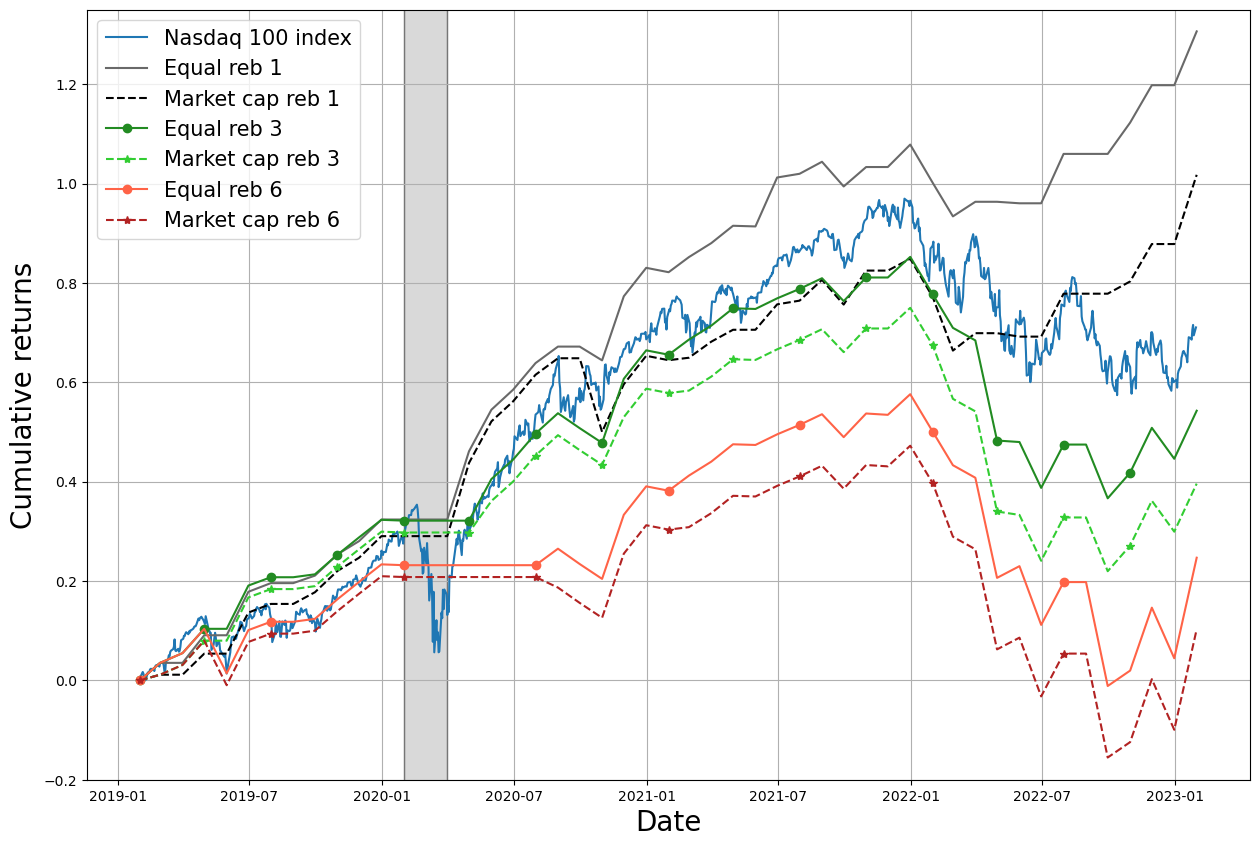

In [13]:
def compare_return_with_nasdaq(optimal_df,Nasdaq100_index,pred_period,pf_type):
    rebalance = 1 # Determine rebalancing frequency
    for k in range(3):
        if k==1:
            rebalance = 3
        elif k==2:
            rebalance = 6
        optimal_new, portfolio_stocks, returns_list, save_i = optimal_hyper(optimal_df,X_test,y_test,dates_df_test_pf,rebalance,pred_period)
        
        # Determine period we are looking at, and find correspodning Nasdaq dates
        if pred_period == 0:
            date_range = pd.date_range(start='2005-01-01', end='2012-01-31', freq='M')
            plot_nas = Nasdaq100_index[(Nasdaq100_index["DATE"]>="2005-01-31") & (Nasdaq100_index["DATE"]<"2012-02-01")]["NASDAQ100"].tolist()
            X_axis = Nasdaq100_index[(Nasdaq100_index["DATE"]>="2005-01-31") & (Nasdaq100_index["DATE"]<"2012-01-31")]["DATE"].tolist()
        elif pred_period == 1:
            date_range = pd.date_range(start='2012-01-01', end='2019-01-31', freq='M')
            plot_nas = Nasdaq100_index[(Nasdaq100_index["DATE"]>="2012-01-31") & (Nasdaq100_index["DATE"]<"2019-02-01")]["NASDAQ100"].tolist()
            X_axis = Nasdaq100_index[(Nasdaq100_index["DATE"]>="2012-01-31") & (Nasdaq100_index["DATE"]<"2019-01-31")]["DATE"].tolist()
        elif pred_period == 2:
            date_range = pd.date_range(start='2019-01-01', end='2023-02-01', freq='M')
            plot_nas = Nasdaq100_index[(Nasdaq100_index["DATE"]>="2019-01-31") & (Nasdaq100_index["DATE"]<"2023-02-01")]["NASDAQ100"].tolist()
            X_axis = Nasdaq100_index[(Nasdaq100_index["DATE"]>="2019-01-31") & (Nasdaq100_index["DATE"]<"2023-01-31")]["DATE"].tolist()
        else:
            print("WRONG INPUT PRED PERIOD")

        ''' PREPARE NASDAQ 100 PLOT '''
        index_list = []
        i = 0
        for x in plot_nas[:]:
            if x == '.':
                plot_nas.remove(x) 
                index_list.append(i)
            i = i+1
        plot_nas = [float(x) for x in plot_nas]
        cum_ret_nas = []
        for i in range(1,len(plot_nas)):
            cum_ret_nas.append(plot_nas[i]/plot_nas[i-1]-1)
        cum_ret_nas = np.cumsum(cum_ret_nas) # Calculate cumulative returns for Nasdaq
        
        # Prepare x-axis for Nasdaq plot 
        X_axis = [x for i, x in enumerate(X_axis) if i not in index_list]
        X_axis = [datetime.datetime.strptime(date_str, "%Y-%m-%d").date() for date_str in X_axis]

        eq = [0]
        mc = [0]

        ''' PREPARE RETURN PLOT'''
        if pf_type == "ls":
            eq = eq + (optimal_new["ls_ret_eq"]).tolist() # Collect lists
            mc = mc + (optimal_new["ls_ret_mc"]).tolist()
        elif pf_type == "bh":
            eq = eq + (optimal_new["bh_ret_eq"]).tolist() # Collect lists
            mc = mc + (optimal_new["bh_ret_mc"]).tolist()
        else:
            print("WRONG INPUT PF TYPE")

        plot_eq = np.cumsum(eq) # Calculate cumulative returns for equal buy/hold
        plot_mc = np.cumsum(mc) # Calculate cumulative returns for mkt cap buy/hold
        
        # Add recession bars to plot
        if pred_period == 0:
            rec_3 = [13847,14395] #rec_3: 2007-12-01, 2009-06-01
            plt.fill_between(rec_3, -1.1, 5.1, facecolor=(0,0,0,.05), edgecolor=(0,0,0,.2))
            plt.ylim(-0.35,2.15)
        elif pred_period == 2:
            rec_4 = [18292,18352] #rec_4: 2020-02-01, 2020-04-01
            plt.fill_between(rec_4, -0.25, 1.51, facecolor=(0,0,0,.05), edgecolor=(0,0,0,.2))
            plt.ylim(-0.2,1.35)
        x_pf = np.array(date_range)
        plt.style.use('default')
        
        # Make sure we do not plot rebalnce points if we can rebalance often or are looking at long/short
        if len(save_i)>40 or pf_type == "ls":
            marker_on = []
        else:
            marker_on = save_i
        
        # Plot
        if k==0:
            plt.plot(X_axis,cum_ret_nas,label = "Nasdaq 100 index")
            plt.plot(x_pf,plot_eq,label = "Equal reb 1",color = "dimgrey")
            plt.plot(x_pf,plot_mc,"--",label = "Market cap reb 1",color = "black")
        
        elif k==1:
            plt.plot(x_pf,plot_eq,"-o",markevery=marker_on,label = "Equal reb 3",color = "forestgreen")
            plt.plot(x_pf,plot_mc,"--*",markevery=marker_on,label = "Market cap reb 3",color = "limegreen")
        elif k==2:
            plt.plot(x_pf,plot_eq,"-o",markevery=marker_on,label = "Equal reb 6", color = "tomato")
            plt.plot(x_pf,plot_mc,"--*",markevery=marker_on,label = "Market cap reb 6",color = "firebrick" )
    
        plt.xlabel("Date",fontsize = 20)
        plt.ylabel("Cumulative returns",fontsize = 20)

        plt.grid()
        plt.legend(loc = 2, fontsize=15)
        
plt.figure(figsize = (15,10))
compare_return_with_nasdaq(optimal_df,Nasdaq100_index,pred_period,"bh")

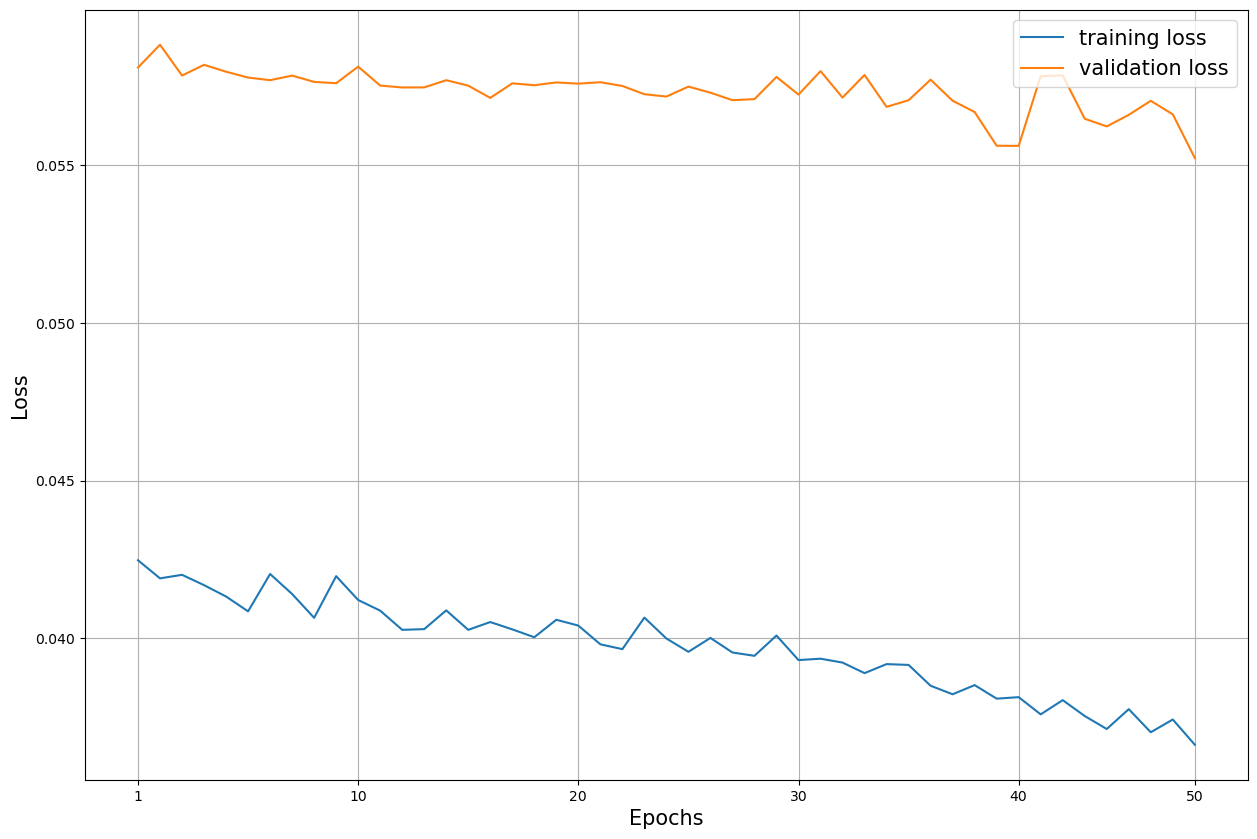

In [14]:
# Prepare loss plots
true_train = []
true_val = []
for j in range(100):
    
    temp_1 = []
    temp_2 = []
    for i in range(0,len(optimal_df),3):
        try:
            temp_1.append(optimal_df["loss_hist"][i]["loss"][j])
            temp_2.append(optimal_df["loss_hist"][i]["val_loss"][j])
        except:
            None
    true_train.append(np.mean(temp_1))
    true_val.append(np.mean(temp_2))
plt.figure(figsize=(15,10))
plt.plot(true_train[1:],label = "training loss")
plt.plot(true_val[1:],label = "validation loss")
x_lab = [1,10,20,30,40,50]
x_ticks = [0,10,20,30,40,48]
plt.xticks(ticks=x_ticks, labels=x_lab)

plt.xlabel("Epochs",fontsize = 15)
plt.ylabel("Loss",fontsize = 15)
plt.grid()
plt.legend(loc=1,fontsize = 15)